In [1]:
## importing required libraries, we will go on importing in our notebook code as we require

import pandas as pd
from sklearn.model_selection import train_test_split
!pip install tensorflow
!pip install keras
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import tensorflow as tf
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.
/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrad

In [2]:
# read data with file name 'converted.csv' with pandas
data = pd.read_csv('converted.csv')
# we shift the Inflation (Can) column by lag specified
data['Inflation (Can)'] = data['Inflation (Can)'].shift(-30)
# other data cleaning steps
data = data.head(84*30)
data.drop(['Period'],axis=1,inplace=True)


In [4]:
# scaling data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)
y = scaled_data[:,0]
x = scaled_data[:,1:]

# applying PCA to reduce feature dimension
from sklearn.decomposition import PCA
pca = PCA(n_components=5)
scaled_data = pca.fit_transform(x)

In [5]:
# splitting data into training and test sets

train_X = scaled_data[:72*30]
train_y = y[:72*30]
test_X = scaled_data[72*30:84*30]
test_y = y[72*30:84*30]

#train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
#test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

In [6]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [13]:
para = {
    'kernel' : ['linear', 'poly', 'rbf', 'sigmoid'],
    'tol' : [0.0001,0.0005,0.001],
    'C' : [0.8,1,1.2]
}
grid_ser = GridSearchCV(SVR(),scoring = 'neg_mean_squared_error',param_grid=para ,n_jobs =5,cv = 4,verbose=5)
grid_ser.fit(train_X,train_y)

Fitting 4 folds for each of 36 candidates, totalling 144 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done  62 tasks      | elapsed:    6.7s
[Parallel(n_jobs=5)]: Done 144 out of 144 | elapsed:   14.3s finished


GridSearchCV(cv=4, error_score=nan,
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='scale', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='deprecated', n_jobs=5,
             param_grid={'C': [0.8, 1, 1.2],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                         'tol': [0.0001, 0.0005, 0.001]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=5)

In [14]:
from numpy import concatenate

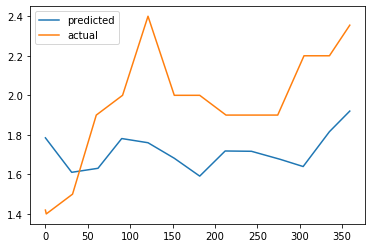

In [15]:
a = scaler.inverse_transform(
    concatenate(
        (grid_ser.best_estimator_.predict(test_X).reshape(360,-1),pca.inverse_transform(test_X)),
         axis=1
    )
)[:,0]

b = scaler.inverse_transform(
    concatenate(
        (test_y.reshape(360,-1),pca.inverse_transform(test_X)),
         axis=1
    )
)[:,0]

pyplot.plot(a, label='predicted')
pyplot.plot(b, label='actual')
pyplot.legend()
pyplot.show()

In [16]:
mean_squared_error(a,b)

0.11908419161045952

In [17]:
mean_absolute_error(a,b)

0.3181164277685724

In [20]:
from sklearn.metrics import r2_score
r2_score(a,b)

-24.98010052581348

In [ ]:
yhat = model.predict(test_X)
test_X1 = pca.inverse_transform(test_X.reshape((test_X.shape[0], test_X.shape[2])))
# invert scaling for forecast
inv_yhat = concatenate((yhat.reshape(12*30,1), test_X1), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y1 = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y1, test_X1), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
#rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
#print('Test RMSE: %.3f' % rmse)
pyplot.plot(inv_yhat, label='predicted')
pyplot.plot(inv_y, label='actual')
pyplot.legend()
pyplot.show()

Epoch 1/7
22/22 - 6s - loss: 0.8745 - val_loss: 0.7171
Epoch 2/7
22/22 - 0s - loss: 0.8499 - val_loss: 0.6875
Epoch 3/7
22/22 - 0s - loss: 0.7349 - val_loss: 0.5350
Epoch 4/7
22/22 - 0s - loss: 0.5910 - val_loss: 0.3999
Epoch 5/7
22/22 - 0s - loss: 0.4948 - val_loss: 0.3513
Epoch 6/7
22/22 - 0s - loss: 0.4306 - val_loss: 0.3468
Epoch 7/7
22/22 - 0s - loss: 0.3838 - val_loss: 0.3574


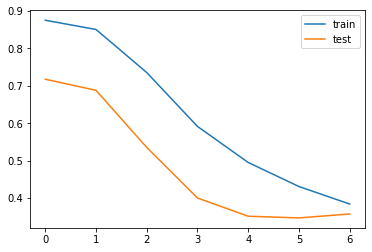

In [483]:
model = Sequential()

model.add(LSTM(128,activation='relu', input_shape=(train_X.shape[1], train_X.shape[2]),return_sequences=True))
model.add(LSTM(128,return_sequences=True))
model.add(LSTM(64,return_sequences=True))
model.add(LSTM(16,return_sequences=True))
model.add(tf.keras.layers.Dropout(0.1))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=7, batch_size=100, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

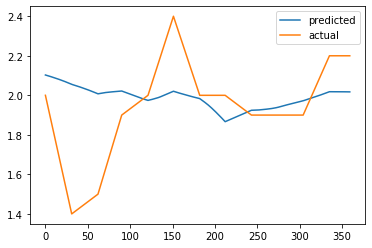

In [484]:
yhat = model.predict(test_X)
test_X1 = pca.inverse_transform(test_X.reshape((test_X.shape[0], test_X.shape[2])))
# invert scaling for forecast
inv_yhat = concatenate((yhat.reshape(12*30,1), test_X1), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y1 = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y1, test_X1), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
#rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
#print('Test RMSE: %.3f' % rmse)
pyplot.plot(inv_yhat, label='predicted')
pyplot.plot(inv_y, label='actual')
pyplot.legend()
pyplot.show()

In [ ]:
yhat = model.predict(pred_X)
test_X1 = pred_X.reshape((pred_X.shape[0], pred_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat.reshape(13,1), test_X1), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y1 = pred_y.reshape((len(pred_y), 1))
inv_y = concatenate((test_y1, test_X1), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
#rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
#print('Test RMSE: %.3f' % rmse)
pyplot.plot(inv_yhat, label='predicted')
pyplot.plot(inv_y, label='actual')
pyplot.legend()
pyplot.show()

In [364]:
data = pd.read_csv('raw_data.csv')
data = data.drop(['Inflation (Can)','Period'],axis=1)

In [57]:
def data_sel(name):
    return pd.read_csv(name+'.csv')
data = data_sel('converted')

In [111]:
def lstm_lag(n):
    data = data_sel('converted')
    data['Inflation (Can)'] = data['Inflation (Can)'].shift(-1*n)
    data = data.head(84*30)
    data.drop(['Period'],axis=1,inplace=True)

    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data)
    y = scaled_data[:,0]
    x = scaled_data[:,1:]
    from sklearn.decomposition import PCA
    pca = PCA(n_components=5)
    scaled_data = pca.fit_transform(x)

    train_X = scaled_data[:72*30]
    train_y = y[:72*30]
    test_X = scaled_data[72*30:84*30]
    test_y = y[72*30:84*30]

    train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

    model = Sequential()

    model.add(LSTM(128,activation='relu', input_shape=(train_X.shape[1], train_X.shape[2]),return_sequences=True))
    model.add(LSTM(128,return_sequences=True))
    model.add(LSTM(64,return_sequences=True))
    model.add(LSTM(16,return_sequences=True))
    model.add(tf.keras.layers.Dropout(0.1))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam')
    # fit network
    history = model.fit(train_X, train_y, epochs=10, batch_size=30, validation_data=(test_X, test_y), verbose=2, shuffle=False)
    # plot history
    #pyplot.plot(history.history['loss'], label='train')
    #pyplot.plot(history.history['val_loss'], label='test')
    #pyplot.legend()
    #pyplot.show()

    yhat = model.predict(test_X)
    test_X1 = pca.inverse_transform(test_X.reshape((test_X.shape[0], test_X.shape[2])))
    # invert scaling for forecast
    inv_yhat = concatenate((yhat.reshape(12*30,1), test_X1), axis=1)
    inv_yhat = scaler.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:,0]
    a = inv_yhat
    # invert scaling for actual
    test_y1 = test_y.reshape((len(test_y), 1))
    inv_y = concatenate((test_y1, test_X1), axis=1)
    inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:,0]
    b = inv_y
    # calculate RMSE
    #rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
    #print('Test RMSE: %.3f' % rmse)
    pyplot.plot(inv_yhat, label='predicted')
    pyplot.plot(inv_y, label='actual')
    pyplot.legend()
    pyplot.title(str(n)+'days lag')
    pyplot.savefig('lstm'+str(n)+'.png')
    pyplot.show()
    return mean_squared_error(a,b),mean_absolute_error(a,b)

In [112]:
def svm_lag(n):
    data = data_sel('converted')
    data['Inflation (Can)'] = data['Inflation (Can)'].shift(-1*n)
    data = data.head(84*30)
    data.drop(['Period'],axis=1,inplace=True)

    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data)
    y = scaled_data[:,0]
    x = scaled_data[:,1:]
    from sklearn.decomposition import PCA
    pca = PCA(n_components=5)
    scaled_data = pca.fit_transform(x)

    train_X = scaled_data[:72*30]
    train_y = y[:72*30]
    test_X = scaled_data[72*30:84*30]
    test_y = y[72*30:84*30]

    #train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    #test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

    para = {
    'kernel' : ['linear', 'poly', 'rbf', 'sigmoid'],
    'tol' : [0.0001,0.0005,0.001,0.01,0.1],
    'C' : [0.1,0.5,1,2]
    }
    grid_ser = GridSearchCV(SVR(),scoring = 'neg_mean_squared_error',param_grid=para ,n_jobs =5,cv = 4,verbose=5)
    grid_ser.fit(train_X,train_y)
    print(grid_ser.best_params_)

    a = scaler.inverse_transform(
    concatenate(
    (grid_ser.best_estimator_.predict(test_X).reshape(360,-1),pca.inverse_transform(test_X)),
     axis=1
    )
    )[:,0]

    b = scaler.inverse_transform(
    concatenate(
    (test_y.reshape(360,-1),pca.inverse_transform(test_X)),
     axis=1
    )
    )[:,0]

    pyplot.plot(a, label='predicted')
    pyplot.plot(b, label='actual')
    pyplot.legend()
    pyplot.title(str(n)+'days lag')
    pyplot.savefig('svm'+str(n)+'.png')
    pyplot.show()
    return mean_squared_error(a,b),mean_absolute_error(a,b)

Fitting 4 folds for each of 96 candidates, totalling 384 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done  62 tasks      | elapsed:    5.3s
[Parallel(n_jobs=5)]: Done 152 tasks      | elapsed:   13.7s
[Parallel(n_jobs=5)]: Done 278 tasks      | elapsed:   26.0s
[Parallel(n_jobs=5)]: Done 384 out of 384 | elapsed:   38.6s finished


{'C': 0.1, 'kernel': 'poly', 'tol': 0.05}


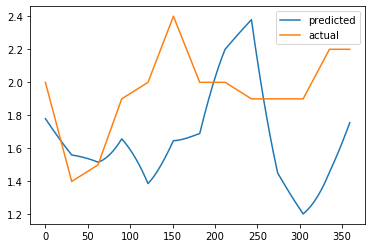

Fitting 4 folds for each of 96 candidates, totalling 384 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.7s
[Parallel(n_jobs=5)]: Done 112 tasks      | elapsed:    8.9s
[Parallel(n_jobs=5)]: Done 202 tasks      | elapsed:   17.1s
[Parallel(n_jobs=5)]: Done 328 tasks      | elapsed:   31.2s
[Parallel(n_jobs=5)]: Done 384 out of 384 | elapsed:   36.5s finished


{'C': 0.1, 'kernel': 'poly', 'tol': 0.05}


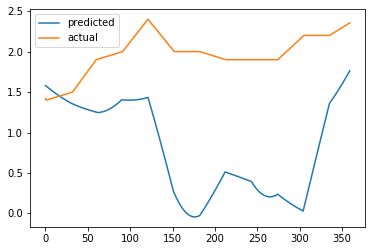

Fitting 4 folds for each of 96 candidates, totalling 384 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done  62 tasks      | elapsed:    3.8s
[Parallel(n_jobs=5)]: Done 152 tasks      | elapsed:   11.9s
[Parallel(n_jobs=5)]: Done 278 tasks      | elapsed:   24.3s
[Parallel(n_jobs=5)]: Done 384 out of 384 | elapsed:   36.9s finished


{'C': 1, 'kernel': 'poly', 'tol': 0.001}


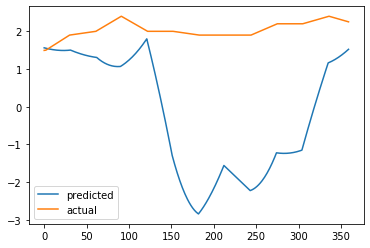

Fitting 4 folds for each of 96 candidates, totalling 384 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.7s
[Parallel(n_jobs=5)]: Done  62 tasks      | elapsed:    3.8s
[Parallel(n_jobs=5)]: Done 152 tasks      | elapsed:   11.9s
[Parallel(n_jobs=5)]: Done 278 tasks      | elapsed:   24.7s
[Parallel(n_jobs=5)]: Done 384 out of 384 | elapsed:   37.8s finished


{'C': 0.1, 'kernel': 'poly', 'tol': 0.05}


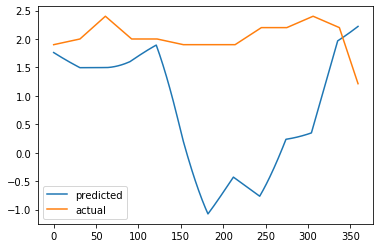

Epoch 1/10
72/72 - 5s - loss: 0.8599 - val_loss: 0.7158
Epoch 2/10
72/72 - 0s - loss: 0.6140 - val_loss: 0.4532
Epoch 3/10
72/72 - 0s - loss: 0.5113 - val_loss: 0.4592
Epoch 4/10
72/72 - 0s - loss: 0.3931 - val_loss: 0.4224
Epoch 5/10
72/72 - 0s - loss: 0.3776 - val_loss: 0.6257
Epoch 6/10
72/72 - 0s - loss: 0.3458 - val_loss: 0.5263
Epoch 7/10
72/72 - 0s - loss: 0.3430 - val_loss: 0.5549
Epoch 8/10
72/72 - 0s - loss: 0.3338 - val_loss: 0.4355
Epoch 9/10
72/72 - 1s - loss: 0.3238 - val_loss: 0.5022
Epoch 10/10
72/72 - 0s - loss: 0.3104 - val_loss: 0.4763


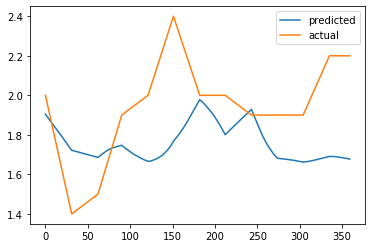

Epoch 1/10
72/72 - 5s - loss: 0.8571 - val_loss: 0.7832
Epoch 2/10
72/72 - 1s - loss: 0.6693 - val_loss: 0.5106
Epoch 3/10
72/72 - 0s - loss: 0.5416 - val_loss: 0.3946
Epoch 4/10
72/72 - 1s - loss: 0.4548 - val_loss: 0.3826
Epoch 5/10
72/72 - 1s - loss: 0.4106 - val_loss: 0.4196
Epoch 6/10
72/72 - 1s - loss: 0.3826 - val_loss: 0.5011
Epoch 7/10
72/72 - 0s - loss: 0.3717 - val_loss: 0.5916
Epoch 8/10
72/72 - 0s - loss: 0.3619 - val_loss: 0.6257
Epoch 9/10
72/72 - 1s - loss: 0.3508 - val_loss: 0.7210
Epoch 10/10
72/72 - 0s - loss: 0.3412 - val_loss: 0.7535


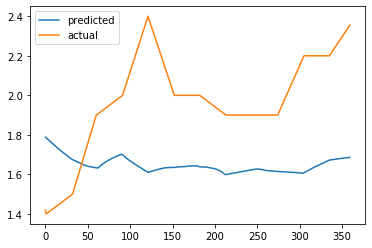

Epoch 1/10
72/72 - 5s - loss: 0.8542 - val_loss: 0.8187
Epoch 2/10
72/72 - 0s - loss: 0.7225 - val_loss: 0.5833
Epoch 3/10
72/72 - 0s - loss: 0.6138 - val_loss: 0.3966
Epoch 4/10
72/72 - 1s - loss: 0.5484 - val_loss: 0.4021
Epoch 5/10
72/72 - 1s - loss: 0.5061 - val_loss: 0.4055
Epoch 6/10
72/72 - 0s - loss: 0.4878 - val_loss: 0.4011
Epoch 7/10
72/72 - 0s - loss: 0.4729 - val_loss: 0.4044
Epoch 8/10
72/72 - 0s - loss: 0.4657 - val_loss: 0.4100
Epoch 9/10
72/72 - 0s - loss: 0.4543 - val_loss: 0.4204
Epoch 10/10
72/72 - 0s - loss: 0.4449 - val_loss: 0.4340


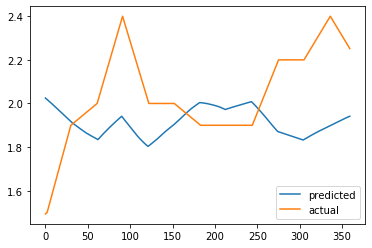

Epoch 1/10
72/72 - 5s - loss: 0.8559 - val_loss: 0.8668
Epoch 2/10
72/72 - 0s - loss: 0.7587 - val_loss: 0.6294
Epoch 3/10
72/72 - 0s - loss: 0.6492 - val_loss: 0.4361
Epoch 4/10
72/72 - 0s - loss: 0.6069 - val_loss: 0.3946
Epoch 5/10
72/72 - 0s - loss: 0.5801 - val_loss: 0.3834
Epoch 6/10
72/72 - 0s - loss: 0.5632 - val_loss: 0.3702
Epoch 7/10
72/72 - 0s - loss: 0.5500 - val_loss: 0.3662
Epoch 8/10
72/72 - 0s - loss: 0.5297 - val_loss: 0.3650
Epoch 9/10
72/72 - 1s - loss: 0.5169 - val_loss: 0.3673
Epoch 10/10
72/72 - 1s - loss: 0.5064 - val_loss: 0.3670


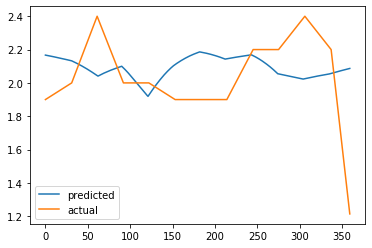

,svm,lstm
0,"(0.20522169794957393, 0.3792480424109322)","(0.08681328449574735, 0.24446629185182234)"
1,"(1.803218879482127, 1.1886776158055903)","(0.17336845273697044, 0.38469009442986896)"
2,"(7.55637150527104, 2.2786586758527116)","(0.07201227890707007, 0.22268377919104354)"
3,"(2.8778132247599344, 1.3895903599612536)","(0.05128468690052659, 0.1850159450615032)"


In [80]:
dicton = {'svm':[svm_lag(0),svm_lag(30),svm_lag(60),svm_lag(90)],
          'lstm':[lstm_lag(0),lstm_lag(30),lstm_lag(60),lstm_lag(90)]}

pd.DataFrame(dicton,index=['no lag','30 days','60 days','90 days'])

Epoch 1/10
72/72 - 5s - loss: 0.8579 - val_loss: 0.8949
Epoch 2/10
72/72 - 0s - loss: 0.7702 - val_loss: 0.7445
Epoch 3/10
72/72 - 0s - loss: 0.6600 - val_loss: 0.5004
Epoch 4/10
72/72 - 1s - loss: 0.6132 - val_loss: 0.4361
Epoch 5/10
72/72 - 1s - loss: 0.5831 - val_loss: 0.4225
Epoch 6/10
72/72 - 0s - loss: 0.5654 - val_loss: 0.4065
Epoch 7/10
72/72 - 0s - loss: 0.5504 - val_loss: 0.3950
Epoch 8/10
72/72 - 1s - loss: 0.5335 - val_loss: 0.3869
Epoch 9/10
72/72 - 1s - loss: 0.5153 - val_loss: 0.3782
Epoch 10/10
72/72 - 1s - loss: 0.5011 - val_loss: 0.3853


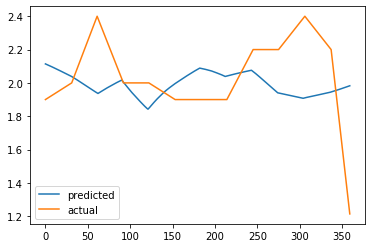

(0.057500998411033774, 0.19421097155125772)

In [110]:
lstm_lag(90)